In [12]:
"""
Author: Seung Won Joeng
Modifier: Kwanyeob Jung, Jaeshin Cho
"""
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
%matplotlib inline               
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn import preprocessing

In [13]:
"""
            TASK 1-2
"""

# Read csv from current path.
def read_csv():
    df1 = pd.read_csv('2020_US_weekly_symptoms_dataset.csv')
    df2 = pd.read_csv('aggregated_cc_by.csv')
    return df1, df2

df1, df2 = read_csv()
print(df1.shape)
print(df2.shape)

(624, 430)
(98434, 62)


/Users/stevenjoeng/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.



In [14]:
"""
            TASK 1-3
"""

# Since we are going to handle regions in USA from 2020_US_weekly_symptoms_dataset.csv
# To extract the records of USA only from dataframe
def extract_from_aggregated(df1, df2):
    # Get all region codes 
    region_codes = df1.open_covid_region_code.unique()
    result = df2[df2['open_covid_region_code'].isin(region_codes)]
    result = result.reset_index(drop = True)
    result = result[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
    return result

df2 = extract_from_aggregated(df1,df2)
print(df2.shape)

(3458, 4)


In [15]:
# Clean data in threshold num_rows * 0.05 and num_cols * 0.05
def clean_dataframe(df):
    num_rows,num_cols = df1.shape
    thresh_rows = int(num_rows * 0.05);
    thresh_cols = int(num_cols * 0.05);
    df = df.dropna(axis = 1, thresh = thresh_rows)
    df = df.dropna(axis = 0, thresh = thresh_cols)
    df = df.reset_index(drop = True)
    return df;

df1 = clean_dataframe(df1)
print('after clean: ', df1.shape)
print(df1.head())

after clean:  (429, 127)
  open_covid_region_code country_region_code country_region sub_region_1  \
0                  US-AK                  US  United States       Alaska   
1                  US-AK                  US  United States       Alaska   
2                  US-AK                  US  United States       Alaska   
3                  US-AK                  US  United States       Alaska   
4                  US-AK                  US  United States       Alaska   

  sub_region_1_code        date  symptom:Adrenal crisis  symptom:Ageusia  \
0             US-AK  2020-01-06                   12.69              NaN   
1             US-AK  2020-01-13                    9.56              NaN   
2             US-AK  2020-01-20                     NaN              NaN   
3             US-AK  2020-01-27                   15.31             7.47   
4             US-AK  2020-02-03                    8.81              NaN   

   symptom:Allergic conjunctivitis  symptom:Amblyopia  ...  \

In [16]:
def convert_to_datetime(df1, df2):
    df1['date'] = pd.to_datetime(df1.date)
    df2['date'] = pd.to_datetime(df2.date)
    return df1,df2

df1, df2 = convert_to_datetime(df1,df2)

In [17]:
def daily_to_weekly(df2):
    df2['date'] = df2['date'] - pd.to_timedelta(7, unit='d')
    df2 = df2.groupby(['open_covid_region_code', pd.Grouper(key='date', freq='W-MON')])['hospitalized_new'].sum().reset_index().sort_values(['open_covid_region_code', 'date'])
    return df2

print(df2['date'])
df2 = daily_to_weekly(df2)
print(df2['date'])

0      2020-03-07
1      2020-03-08
2      2020-03-09
3      2020-03-10
4      2020-03-11
          ...    
3453   2020-10-03
3454   2020-10-04
3455   2020-10-05
3456   2020-10-06
3457   2020-10-07
Name: date, Length: 3458, dtype: datetime64[ns]
0     2020-03-02
1     2020-03-09
2     2020-03-16
3     2020-03-23
4     2020-03-30
         ...    
508   2020-09-07
509   2020-09-14
510   2020-09-21
511   2020-09-28
512   2020-10-05
Name: date, Length: 513, dtype: datetime64[ns]


In [18]:
"""
            TASK 1-4
"""
# Merge two data, delete unnecessary columns
def merge_two_dfs(df1, df2):
    result = df1.merge(df2, how='inner', on=['open_covid_region_code', 'date'])
    result = result.reset_index(drop = True)
    result.drop('country_region', axis='columns', inplace=True)
    result = result.fillna(0)
    return result

final = merge_two_dfs(df1,df2)
print(final.head())

  open_covid_region_code country_region_code sub_region_1 sub_region_1_code  \
0                  US-AK                  US       Alaska             US-AK   
1                  US-AK                  US       Alaska             US-AK   
2                  US-AK                  US       Alaska             US-AK   
3                  US-AK                  US       Alaska             US-AK   
4                  US-AK                  US       Alaska             US-AK   

        date  symptom:Adrenal crisis  symptom:Ageusia  \
0 2020-03-02                   14.62             0.00   
1 2020-03-09                   10.60             0.00   
2 2020-03-16                   11.69             0.00   
3 2020-03-23                   11.15            16.57   
4 2020-03-30                    8.96             8.96   

   symptom:Allergic conjunctivitis  symptom:Amblyopia  symptom:Amenorrhea  \
0                             0.00                0.0                9.97   
1                           

In [19]:
#### TASK 2!!!!!!!!!!


In [20]:
"""
            TASK 3
"""

# df: mereged data
# Case1) To keep all data from some regions in the val set and train on the rest
def split_data_regions(df):
    regions = df.open_covid_region_code.unique()
    col_name = 'open_covid_region_code'
    kf = KFold()
    for train_index, val_index in kf.split(regions):
        
        train, validation = regions[train_index], regions[val_index]
        
        train_df = df[df[col_name].isin(train)]
        val_df = df[df[col_name].isin(validation)]
        
        X_train = train_df.iloc[:, 5:-1]
        Y_train = train_df['hospitalized_new']
#         print("X_train: \n", X_train.head(3))
#         print("Y_train: \n", Y_train.head(3))
        
        X_val = val_df.iloc[:, 5:-1]
        Y_val = val_df['hospitalized_new']
#         print("X_validation: \n", X_val.head(3))
#         print("Y_validation: \n", Y_val.head(3))
#         X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
#         X_val = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
#         Y_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
#         Y_val = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
        yield X_train, Y_train, X_val, Y_val, train

    
# Case2) To keep data for the last couple of timepoints (keep data after 2020-08-10) from all regions in the va
# set and train on the rest
# df: merged data // date: date as string
def split_data_time(df, d):
    # Convert to datetime from String
    date = datetime.strptime(d, '%Y-%m-%d')
    
    train_df = df[df["date"] <= date]
    val_df = df[df["date"] > date]
    
    X_train = train_df.iloc[:, 5:-1]
    Y_train = train_df['hospitalized_new']
    
    X_val = val_df.iloc[:, 5:-1]
    Y_val = val_df['hospitalized_new']
    return X_train, Y_train, X_val, Y_val, train_df['date']



In [21]:
"""
            TASK 3: KNeighborsRegressor
            @Params: k:int, X_train, Y_train, X_val: dataframe
"""

def KNN_regression(k, X_train, Y_train, X_val):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, Y_train)
    pred = neigh.predict(X_val)
    return pred


"""
            TASK 3: DecisionTreeRegressor
            @Params: l:int, X_train, Y_train, X_val: dataframe
"""
def DecisionTree_regression(l, X_train, Y_train, X_val):
    model = DecisionTreeRegressor(min_samples_leaf=l)
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    return pred


[BASED ON REGION] K:  40
[BASED ON REGION] Minimum MSE:  23.093681058651296
[BASED ON REGION] Regions used in Train: 
 ['US-AK' 'US-DC' 'US-DE' 'US-ND' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


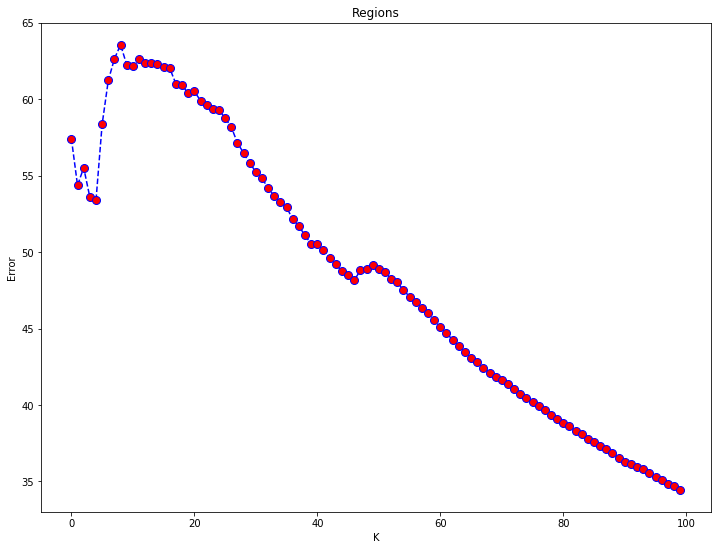

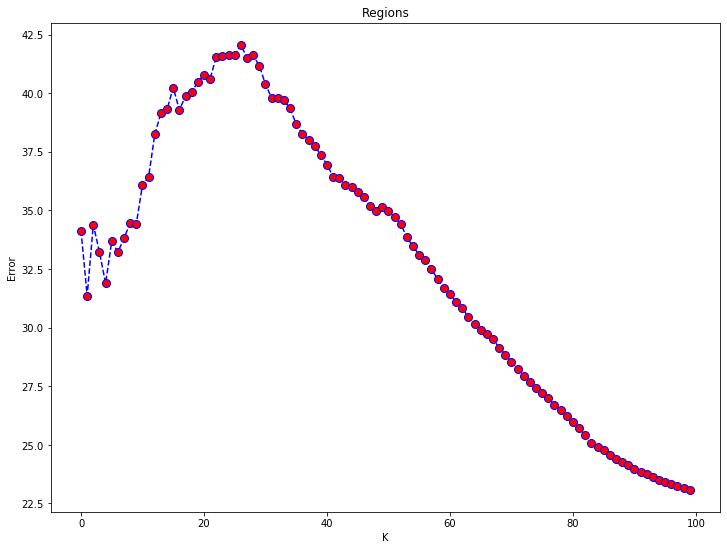

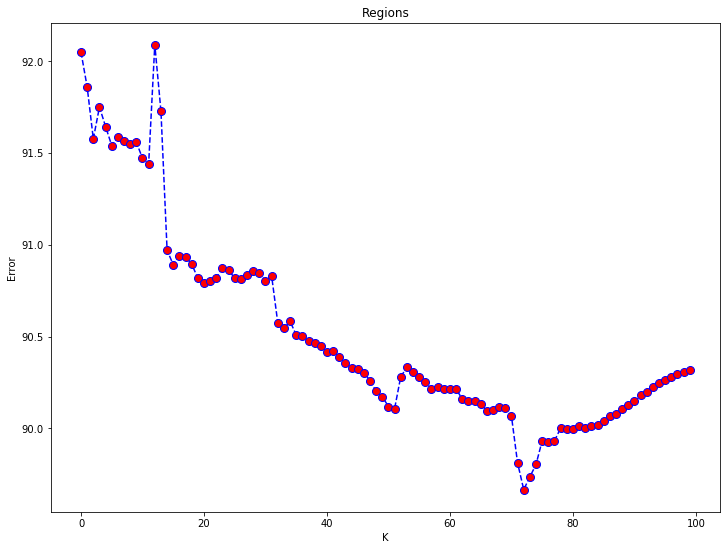

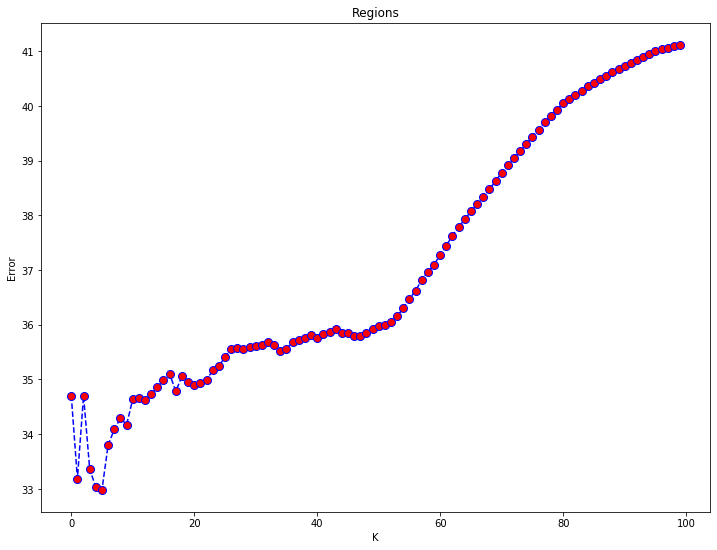

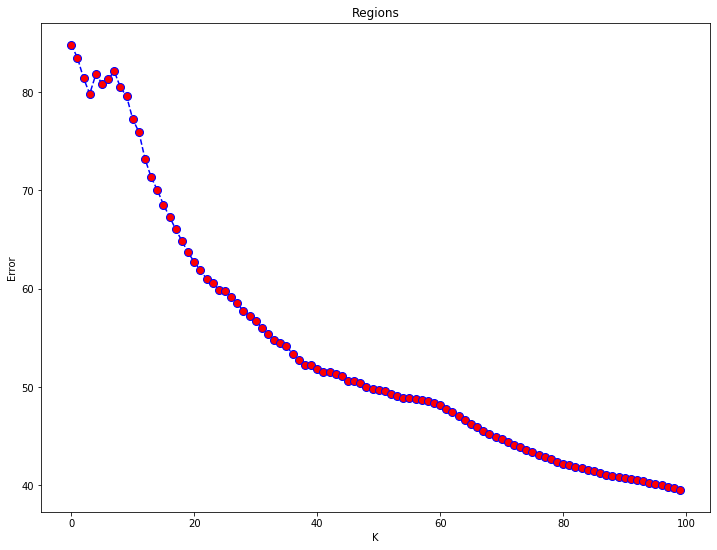

In [22]:
"""
            TASK 3: KNeighborsRegressor based on regions
"""

errors_knn = []
errors_tmp = []
fold_regions = []

for X_train, Y_train, X_val, Y_val, train in split_data_regions(final): 
    for n in range(100):
        pred = KNN_regression(n+1, X_train, Y_train, X_val)
        mse = mean_squared_error(Y_val, pred, squared=False)
        errors_knn.append(mse)
        errors_tmp.append(mse)
        fold_regions.append(train)
        
    plt.figure(figsize=(12,9))
    plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
    plt.title('Regions')
    plt.ylabel('Error')
    plt.xlabel('K')
    errors_tmp = []
        

err = np.array(errors_knn)
min_index = np.argmin(err)
k = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_regions[min_index]


print('[BASED ON REGION] K: ', k)
print('[BASED ON REGION] Minimum MSE: ', min_err)
print('[BASED ON REGION] Regions used in Train: \n', min_reg)


[BASED ON TIME] K:  2
[BASED ON TIME] Minimum MSE:  33.017497656775134
[BASED ON TIME] Dates used in Train: 
 ['US-ME' 'US-MT' 'US-ND' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY'] 
[BASED ON TIME] Time:  2020-08-01


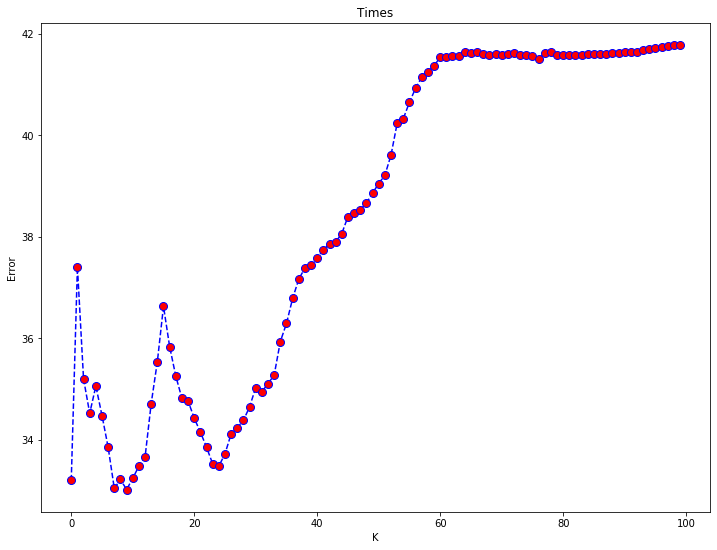

In [23]:
"""
            TASK 3: KNeighborsRegressor based on times
"""

errors_knn = []
errors_tmp = []
fold_times = []
d = '2020-08-01'

X_train, Y_train, X_val, Y_val, train = split_data_time(final, d)

for n in range(100):
    pred = KNN_regression(n+1, X_train, Y_train, X_val)
    mse = mean_squared_error(Y_val, pred, squared=False)
    errors_knn.append(mse)
    errors_tmp.append(mse)
    fold_times.append(train)
    
plt.figure(figsize=(12,9))
plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
plt.title('Times')
plt.ylabel('Error')
plt.xlabel('K')

# for X_train, Y_train, X_val, Y_val, train in split_data_time(final, d):
#     for n in range(100):
#         pred = KNN_regression(n+1, X_train, Y_train, X_val)
#         mse = mean_squared_error(Y_val, pred, squared=False)
#         errors_knn.append(mse)
#         errors_tmp.append(mse)
#         fold_times.append(train)
    
#     plt.figure(figsize=(12,9))
#     plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
#     plt.title('Times')
#     plt.ylabel('Error')
#     plt.xlabel('K')
#     errors_tmp = []

err = np.array(errors_knn)
min_index = np.argmin(err)
k = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_regions[min_index]

print('[BASED ON TIME] K: ', k)
print('[BASED ON TIME] Minimum MSE: ', min_err)
print('[BASED ON TIME] Dates used in Train: \n', min_reg, '\n[BASED ON TIME] Time: ', d)

[BASED ON REGION] Leaf:  23
[BASED ON REGION] Minimum MSE:  20.556081298601356
[BASED ON REGION] Regions used in Train: 
 ['US-AK' 'US-DC' 'US-DE' 'US-ND' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


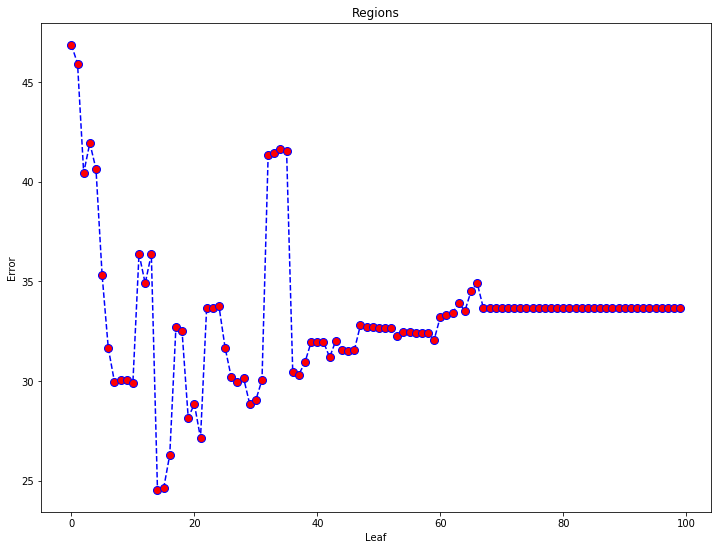

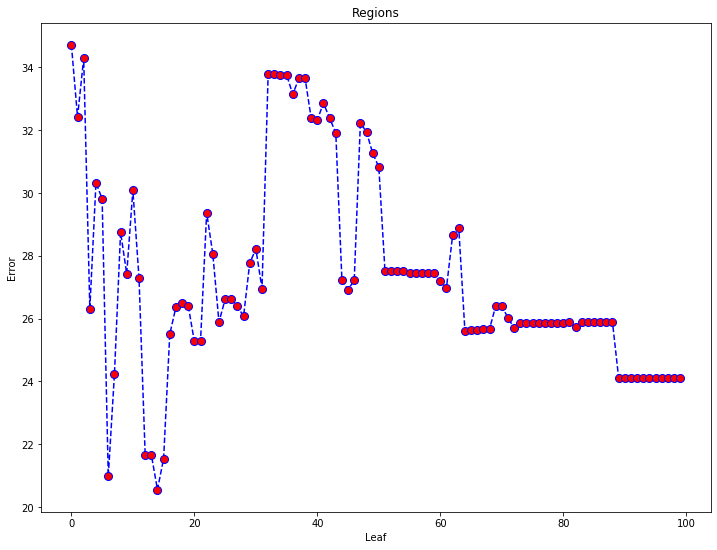

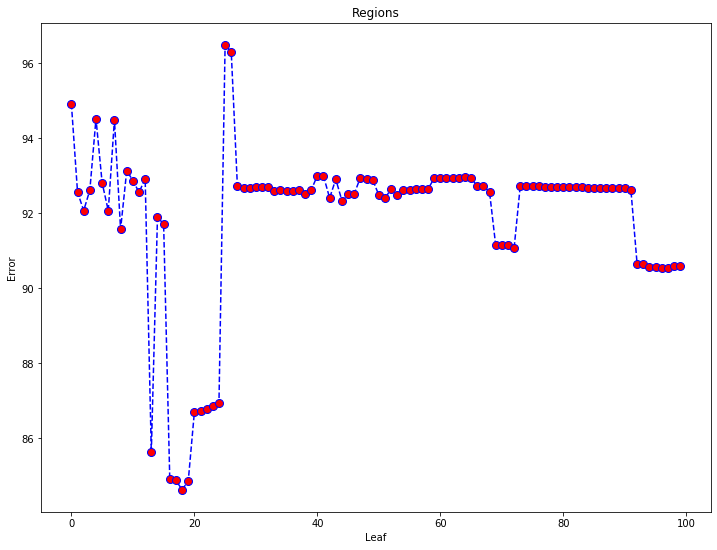

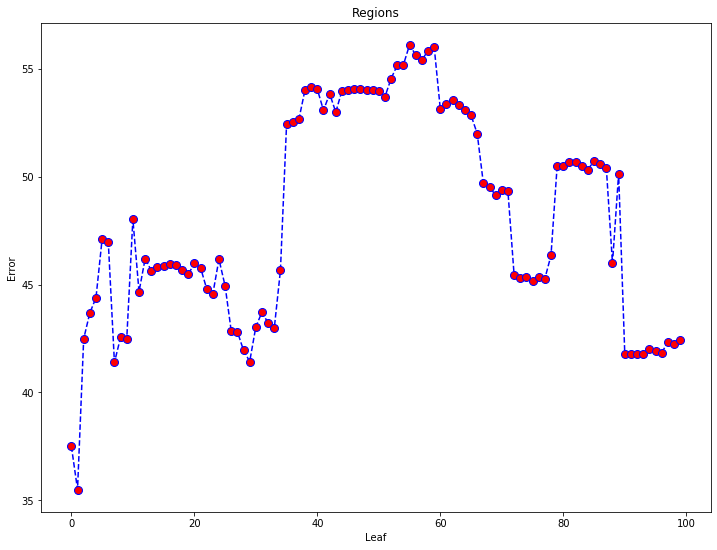

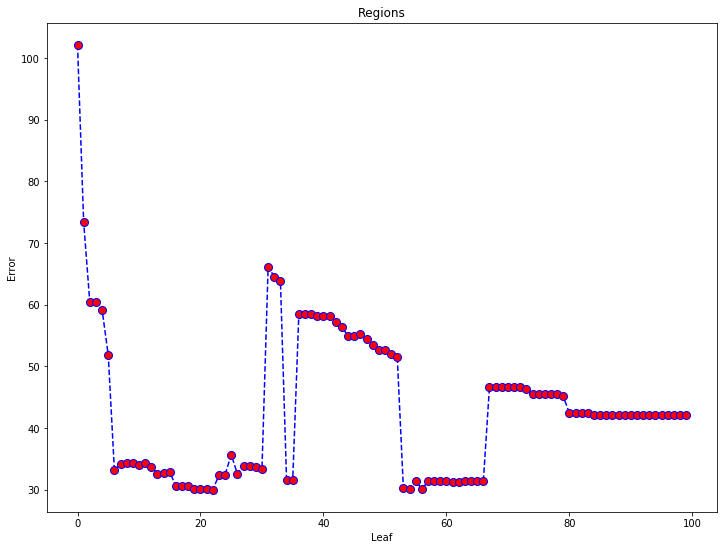

In [24]:
"""
            TASK 3: DecisionTreeRegressor based on regions
"""

errors_tmp = []
errors_dt = []
fold_regions = []


for X_train, Y_train, X_val, Y_val, train in split_data_regions(final):
    for l in range(100):
        pred = DecisionTree_regression(l+1, X_train, Y_train, X_val)
        mse = mean_squared_error(Y_val, pred, squared=False)
        errors_dt.append(mse)
        errors_tmp.append(mse)
        fold_regions.append(train)
        
    plt.figure(figsize=(12,9))
    plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
    plt.title('Regions')
    plt.ylabel('Error')
    plt.xlabel('Leaf')
    errors_tmp = []
        

err = np.array(errors_dt)
min_index = np.argmin(err)
l = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_regions[min_index]

print('[BASED ON REGION] Leaf: ', l)
print('[BASED ON REGION] Minimum MSE: ', min_err)
print('[BASED ON REGION] Regions used in Train: \n', min_reg)





[BASED ON TIME] L:  7
[BASED ON TIME] Minimum MSE:  1080.2631105429753
[BASED ON TIME] Times used in Train: 
 0     2020-03-02
1     2020-03-09
2     2020-03-16
3     2020-03-23
4     2020-03-30
         ...    
328   2020-06-29
329   2020-07-06
330   2020-07-13
331   2020-07-20
332   2020-07-27
Name: date, Length: 243, dtype: datetime64[ns] 
[BASED ON TIME] Time:  2020-08-01


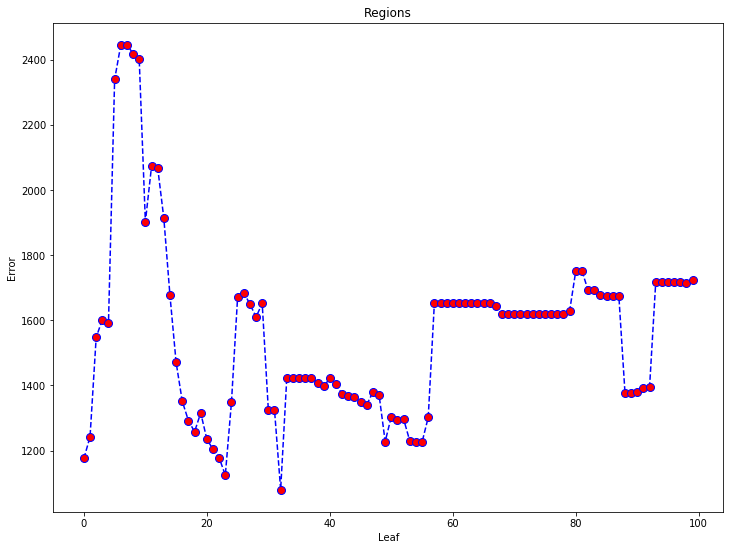

In [25]:

"""
            TASK 3: DecisionTreeRegressor based on times
"""
errors_tmp = []
errors_dt = []
fold_times = []
d = '2020-08-01'

X_train, Y_train, X_val, Y_val, train = split_data_time(final, d)

for l in range(100):
    pred = DecisionTree_regression(l+1, X_train, Y_train, X_val)
    mse = mean_squared_error(Y_val, pred)
    errors_dt.append(mse)
    errors_tmp.append(mse)
    fold_times.append(train)

plt.figure(figsize=(12,9))
plt.plot(range(100), errors_tmp, color='blue', markerfacecolor='red', linestyle='dashed', marker='o', markersize=8)
plt.title('Regions')
plt.ylabel('Error')
plt.xlabel('Leaf')
errors_tmp = []


err = np.array(errors_dt)
min_index = np.argmin(err)
l = (min_index // 5) + 1
min_err = err[min_index]
min_reg = fold_times[min_index]

print('\n')
print('[BASED ON TIME] L: ', l)
print('[BASED ON TIME] Minimum MSE: ', min_err)
print('[BASED ON TIME] Times used in Train: \n', min_reg, '\n[BASED ON TIME] Time: ', d)
